# 잠재 요인 협업 필터링
* 상요자-아이템 평점 매트릭스 속에 숨어있는 **잠재 요인을 추출**해 추천 예측을 할 수 있게 하는 기법
    * 잠재 요인이 어떤 것인지는 명확히 정의 불가능

### 행렬 분해
* 다차원의 매트릭스를 저차원 매트릭스로 분해라는 기법
    * SVD(Singular Vector Decomposition), NMF(Non-Negative Matrix Factorication) 등

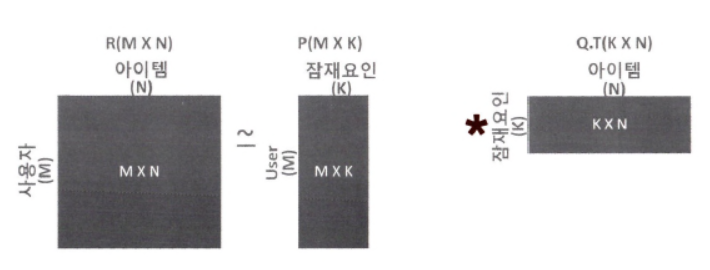

* 행렬 R = M * N 차원, M개의 사용자 행과 N개의 아이템 열을 가진 평점 행렬
* 행렬 분해 => 사용자-K 차원 잠재 요인 행렬 P(M * K 차원)과 K 차원 잠재 요인 - 아이템 행렬 Q.T(K * N 차원)
    * Q는 아이템-잠재 요인 행렬, Q.T는 Q의 전치 행렬인 잠재 요인 - 아이템 행렬
* R = P * Q.T
    * M은 총 사용자 수
    * N은 총 아이템 수
    * K는 잠재 요인의 차원 수
    * R은 M * N 차원의 사용자 - 아이템 평점 행렬
    * P는 사용자와 잠재 요인과의 관계 값을 가지는 M * K 차원의 사용자-잠재 요인 행렬
    * Q는 아이템과 잠재 요인과의 관계 값을 가지는 N * K 차원의 아이템-잠재 요인 행렬
    * Q.T는 Q 매트릭스의 행과 열 값을 교환한 전치 행렬

### 확률적 경사 하강법을 이용한 행렬 분해
* P와 Q 행렬로 계산된 예측 R 행렬 값이 실제 R 행렬 값과 가장 최소의 오류를 가질 수 있도록 반복적인 비용 함수 최적화를 통해 P와 Q를 유추하는 것.
* Null 값이 있는 행렬도 행렬 분해 가능
* 과정
    1. P와 Q를 임의의 값을 가진 행렬로 설정
    2. P와 Q.T 값을 곱해 예측 R 행렬을 계산하고 예측 R 행렬과 실제 R 행렬에 해당하는 오류 값을 계산.
    3. 이 오류 값을 최소화할 수 있도록 P, Q 행렬을 적절한 값으로 업데이트.
    4. 만족할만한 오류 값을 가질 때까지 2, 3번 작업을 반복 -> P와 Q 업데이트하여 근사화

* 실제값과 예측값의 오류 최소화와 L2 규제를 고려한 비용 함수식

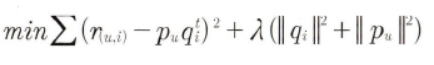

* 비용 함수를 최소화하기 위해서 새롭게 업데이트되는 P, Q


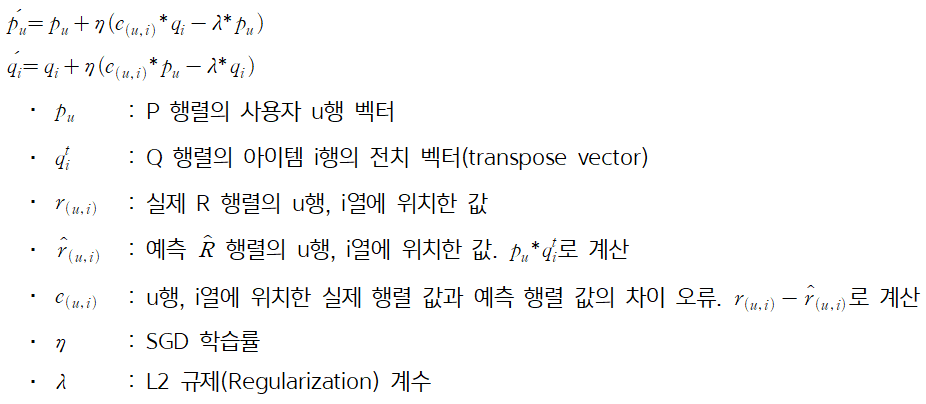

In [1]:
# 행렬 분해 - SGD
# 분해하려는 원본 행렬 R을 P와 Q로 분해한 뒤 다시 P와 Q.T의 내적으로 예측 행렬
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재 요인 차원 K는 3으로 설정
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN ],
              [np.NaN, 5, np.NaN, 3, 1 ],
              [np.NaN, np.NaN, 3, 4, 4 ],
              [5, 2, 1, 2, np.NaN ]])
num_users, num_items = R.shape
K = 3

# P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 random한 값으로 입력
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

In [2]:
# 실제 R 행렬과 예측 행렬의 오차를 구하는 함수
# 실제 R 행렬의 널이 아닌 행렬 값의 위치 인덱스를 추출해
# 이 인덱스에 있는 실제 R 행렬 값과 분해된 P, Q를 이용해 
# 다시 조합된 예측 행렬 값의 RMSE 값 반환
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 인덱스 추출하여 실제 R행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros  = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    return np.sqrt(mse)

* SGD 기반 행렬 분해
    * R에서 널 값을 제외한 데이터의 행렬 인덱스 추출
    * steps : SGD를 반복해서 업데이터할 횟수
    * learning_rate : SGD의 학습률
    * r_lambda : L2 Regularization 계수

In [3]:
# R > 0 인 행 위치, 열 위치 값을 non_zeros 리스트에 저장
non_zeros = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]

steps = 1000
learning_rate = 0.01
r_lambda = 0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
for step in range(steps):
    for i, j, r in non_zeros:
        # 실제 값과 예측 값의 차이인 오류 값 구함
        eij = r - np.dot(P[i, :], Q[j, :].T)
        # Regularization을 반영한 SGD 업데이트 공식 적용
        P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
        Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
    rmse = get_rmse(R, P, Q, non_zeros)
    if step % 50 == 0:
        print("### iteration step : ", step," rmse : ", rmse)

### iteration step :  0  rmse :  3.2388050277987723
### iteration step :  50  rmse :  0.4876723101369647
### iteration step :  100  rmse :  0.15643403848192458
### iteration step :  150  rmse :  0.07455141311978064
### iteration step :  200  rmse :  0.043252267985793146
### iteration step :  250  rmse :  0.029248328780879226
### iteration step :  300  rmse :  0.022621116143829507
### iteration step :  350  rmse :  0.019493636196525232
### iteration step :  400  rmse :  0.018022719092132773
### iteration step :  450  rmse :  0.01731968595344283
### iteration step :  500  rmse :  0.016973657887570985
### iteration step :  550  rmse :  0.01679680459589558
### iteration step :  600  rmse :  0.016701322901884634
### iteration step :  650  rmse :  0.016644736912476574
### iteration step :  700  rmse :  0.016605910068210012
### iteration step :  750  rmse :  0.01657420047570488
### iteration step :  800  rmse :  0.01654431582921612
### iteration step :  850  rmse :  0.016513751774735037
### i

In [4]:
pred_matrix = np.dot(P, Q.T)
print("예측 행렬 :\n", np.round(pred_matrix, 3))

예측 행렬 :
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]
